In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"


sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from RotationCurveFit import RotationCurveFit, GaussFit_signle
from ChainTool import ChainTool
from chainconsumer import ChainConsumer

# setup parameters

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5


pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


# generate mock data

In [3]:
dataInfo = gen_mock_tfCube(pars, line_species, noise_mode=0)

# 2D spec 

In [12]:
thresholdSNR = 5e-6
is_weightSNR = 0
# init Fit tool
RotFit = RotationCurveFit(dataInfo, \
                          active_par_key = ['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'theta_int'], \
                          thresholdSNR = thresholdSNR, is_weightSNR=is_weightSNR) #

(112, 122)
(52, 122)
time cost in gaussFit_spec2D: 0.04424309730529785 (secs)
(125, 122)
(48, 122)
time cost in gaussFit_spec2D: 0.036875009536743164 (secs)


In [13]:
RotFit.spec[0].spaceGrid.shape

(52,)

In [14]:
RotFit.spec[1].spaceGrid.shape

(48,)

In [15]:
RotFit.spec_stats[1]['peakLambda'].shape

(48,)

In [16]:
active_par_test = np.zeros(len(RotFit.active_par_key))
for j, item in enumerate(RotFit.active_par_key):
    active_par_test[j] = RotFit.par_fid[item]
active_par_test

array([200. ,   0.5,   0.5,   0. ,   0. ,   0. ,   0. ,   0. ])

In [17]:
chi2 = RotFit.cal_chi2(active_par=active_par_test)
chi2

0.03435871815660528

In [18]:
%time loglike = RotFit.cal_loglike(active_par=active_par_test)
loglike

CPU times: user 205 µs, sys: 0 ns, total: 205 µs
Wall time: 209 µs


-0.01717935907830264

In [19]:
active_par_test[0] = 190.
loglike = RotFit.cal_loglike(active_par=active_par_test)
loglike

-0.15197588901385067

In [20]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)

100%|██████████| 3000/3000 [00:19<00:00, 153.26it/s]

Total MCMC time (mins): 0.32667467594146726


In [21]:
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

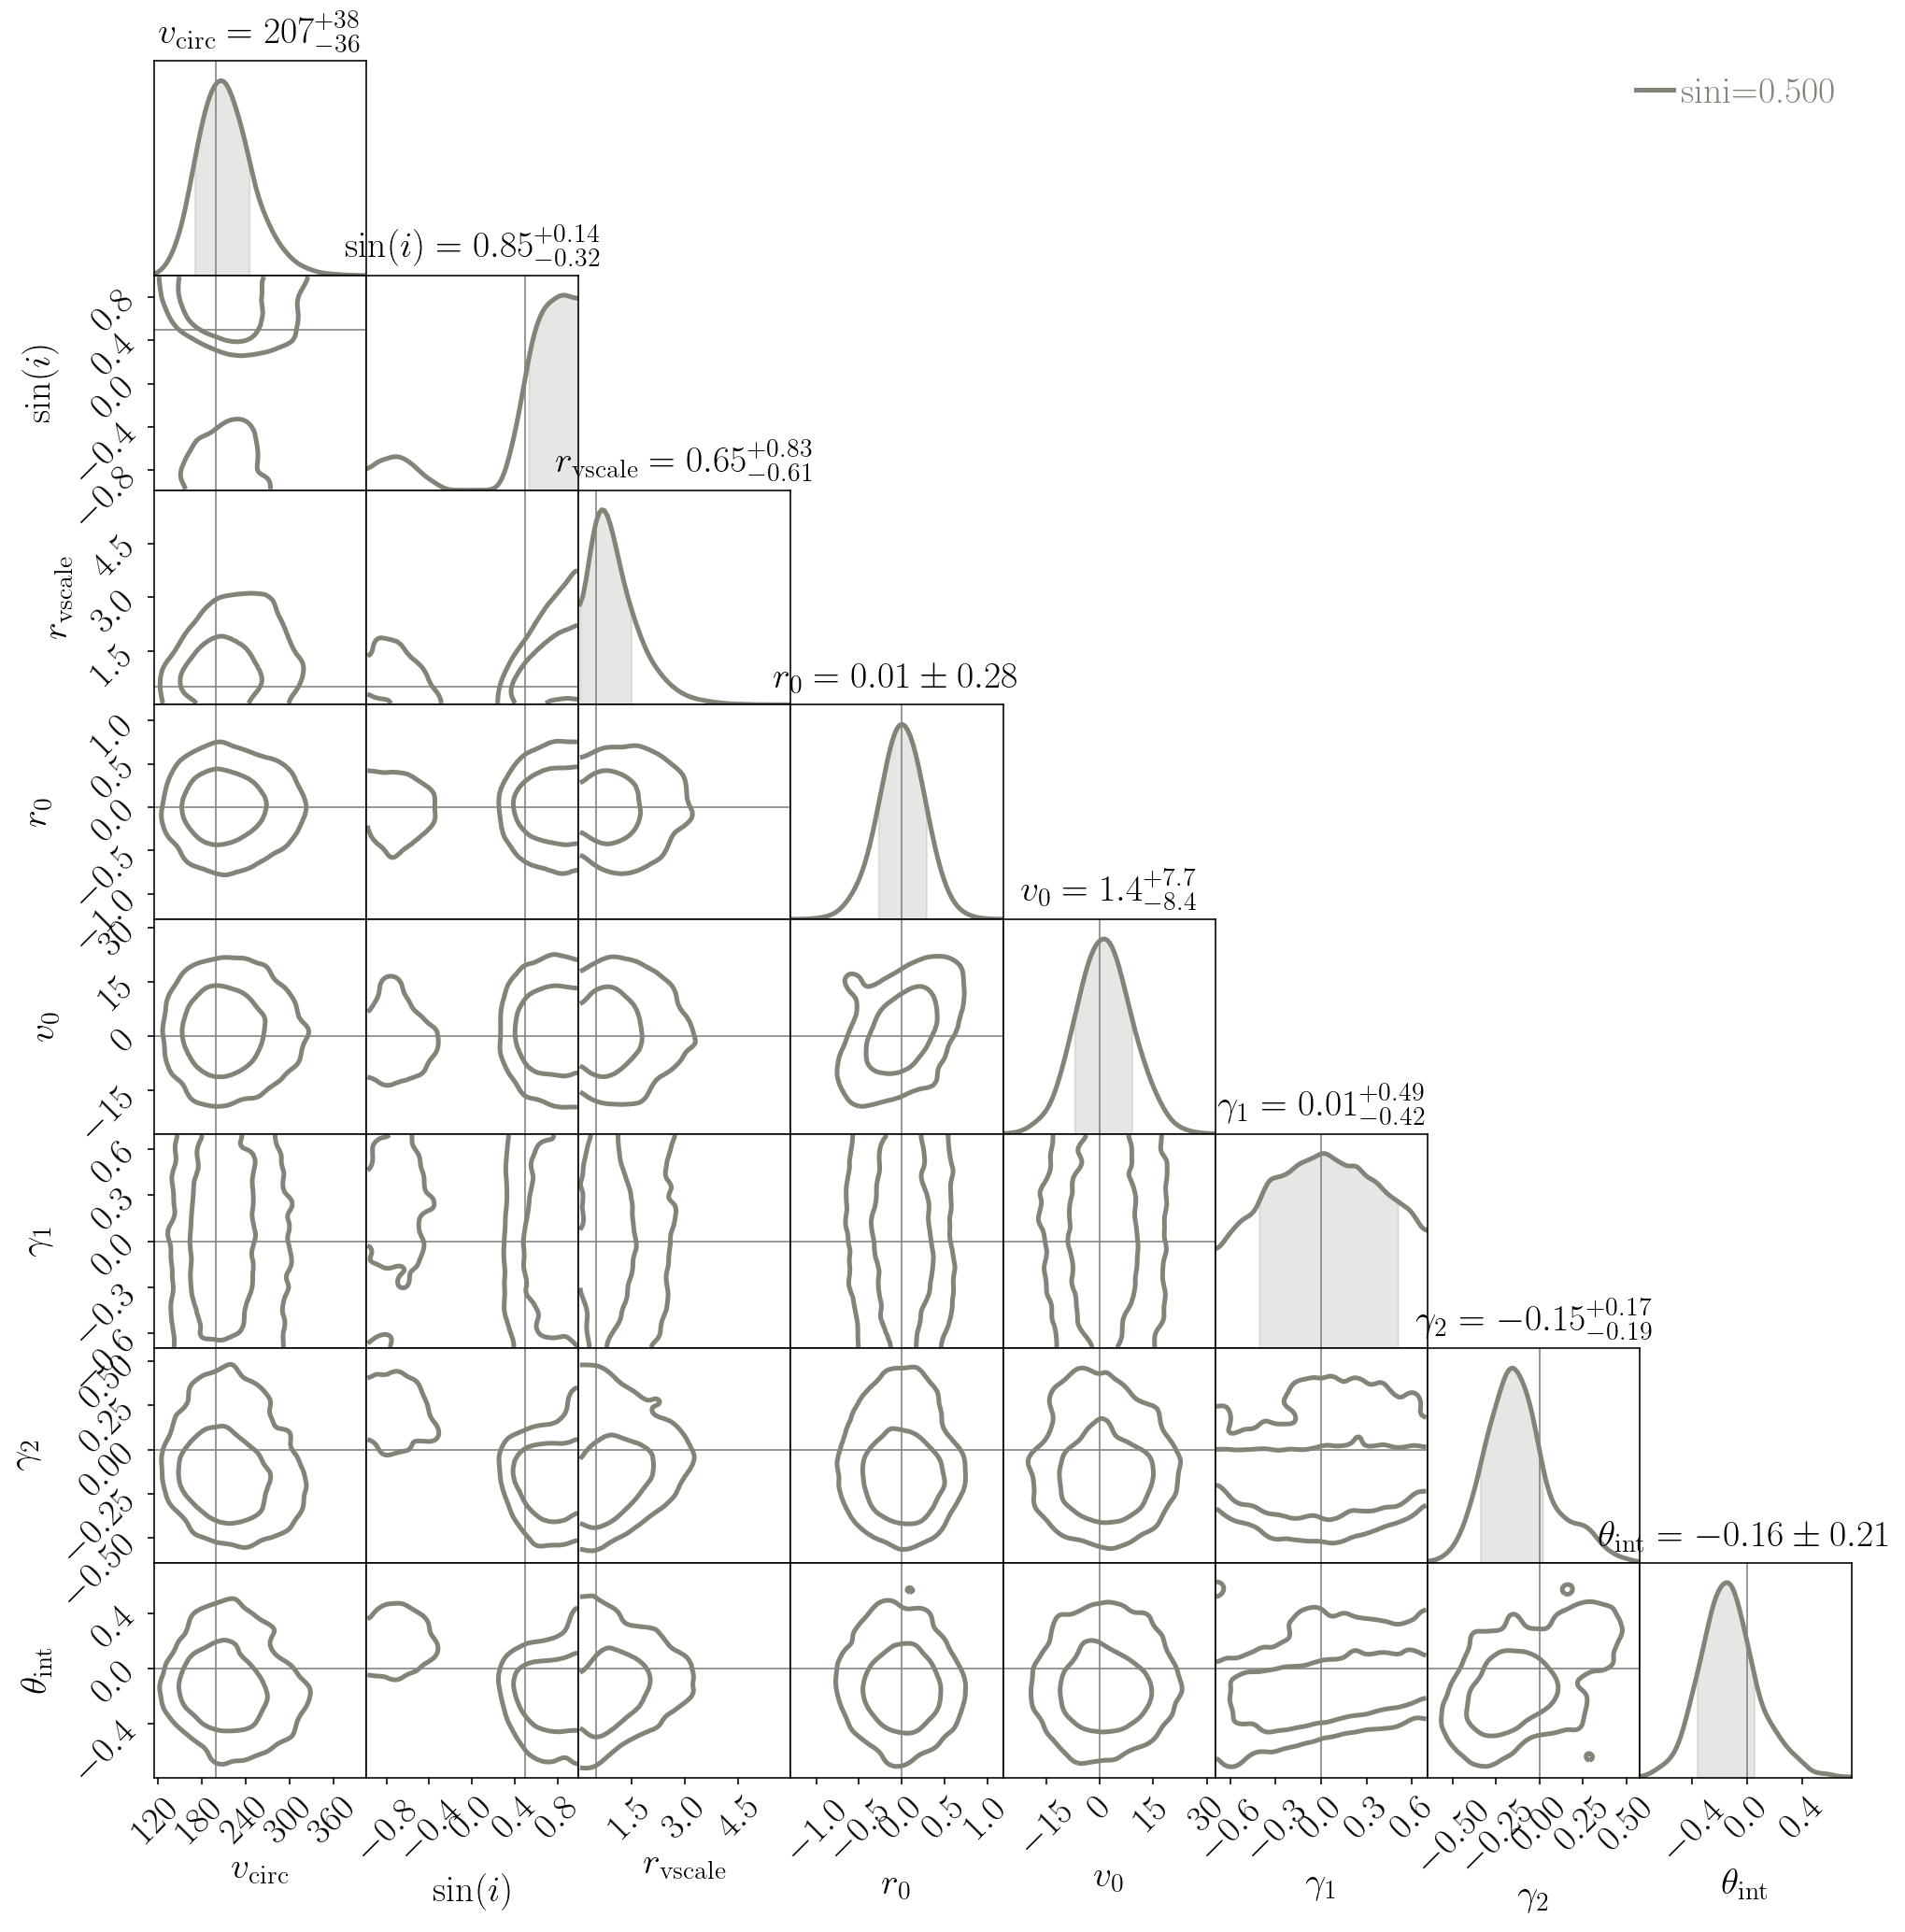

In [22]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = RotFit.active_par_key #, 'vscale' , 'sini'
legend_chain = "sini=%.3f"%pars['sini']

parID1, parName1, par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
#fig.savefig("fig1.pdf", transparent=True)

# Plot spectrum

In [ ]:
# get pixel edges

j=0

spec2D = RotFit.spec[j]

lambda_min = np.min(spec2D.lambdaGrid)  ; lambda_MAX = np.max(spec2D.lambdaGrid)
x_min = np.min(spec2D.spaceGrid)        ; x_MAX = np.max(spec2D.spaceGrid)

lambda0 = RotFit.lambda0
lambdaGrid, spaceGrid = spec2D.lambdaGrid, spec2D.spaceGrid

######

GaussFit = GaussFit_signle(spec2D=spec2D, lambda0=lambda0, thresholdSNR=RotFit.thresholdSNR)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D()
model = GaussFit.model_spec2D(fitted_peakLambda, fitted_amp, fitted_sigma)
data = GaussFit.spec2D.array

%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T), extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])


#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(spaceGrid[1::3], fitted_peakLambda[1::3], fitted_sigma[1::3] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')
ax[0].errorbar(spaceGrid[1::3], fitted_peakLambda[1::3], fitted_sigma[1::3] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')


#### result of fiducial rotation curve (black)
par_fid = RotFit.par_fid.copy()
fidicual_rot = RotFit.model_arctan_rotation(r=spaceGrid, vcirc=par_fid['vcirc'], sini=par_fid['sini'], \
                                           vscale=par_fid['vscale'], r_0=par_fid['r_0'], v_0=par_fid['v_0'], \
                                           g1=par_fid['g1'], g2=par_fid['g2'], theta_int=par_fid['theta_int'], \
                                           redshift=par_fid['redshift'], slitAngle=par_fid['slitAngles'][j])

# theta_test = 120.
# theta_test = theta_test * np.pi/180.
# fidicual_rot = RotFit.model_arctan_rotation(r=spaceGrid, vcirc=par_fid['vcirc'], sini=par_fid['sini'], \
#                                             vscale=par_fid['vscale'], r_0=par_fid['r_0'], v_0=par_fid['v_0'], \
#                                             g1=par_fid['g1'], g2=par_fid['g2'], theta_int=par_fid['theta_int'], \
#                                             redshift=par_fid['redshift'], slitAngle=theta_test)
ax[1].plot(spaceGrid[2::4],fidicual_rot[2::4],color='b',ls='-',label='fiducial rot.', zorder=10)


#### result of bestfit from MCMC sampling (red)
# par_BF_MC = Chain.par_bestfit(select_par_key=None, statistics='max', mode=0)

# MC_rot = RotFit.model_arctan_rotation(spaceGrid, vcirc=par_BF_MC['vcirc'][1], \
#                                       sini=par_BF_MC['sini'][1], vscale=par_BF_MC['vscale'][1], \
#                                       r_0=par_BF_MC['r_0'][1], v_0=par_BF_MC['v_0'][1], \
#                                       redshift=par_fid['redshift'], slitAngle=par_fid['slitAngles'][j])

# ax[1].plot(spaceGrid[2::6],MC_rot[2::6],color='r',ls='--',label='arctan rot (MCMC)')


lambda_cen = lambda0*(1.+dataInfo['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='lightgray')
ax[0].axhline(lambda_cen, color='lightgray')


for j in range(ncol):
    #ax[j].set_ylim(786.5,789.0)
    ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    #ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

# ====== weight_SNR ======

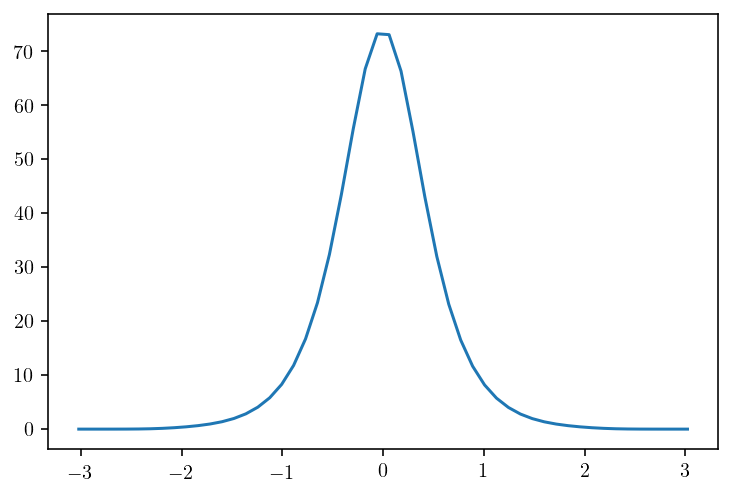

In [23]:
plt.plot(RotFit.spec[0].spaceGrid, RotFit.spec[0].SNR_pos)

In [13]:
RotFit.spec[0].SNR_pos.mean()

13.412169442694571

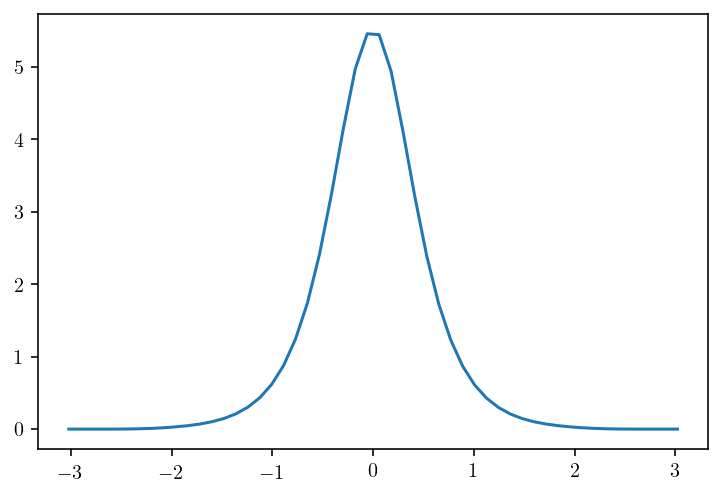

In [14]:
weight_SNR = RotFit.spec[0].SNR_pos/RotFit.spec[0].SNR_pos.mean()
plt.plot(RotFit.spec[0].spaceGrid, weight_SNR)

In [15]:
np.sum(weight_SNR)

1.0000000000000002

In [15]:
np.mean(weight_SNR)

1.0000000000000002